# REINFORCE in pytorch

Just like we did before for q-learning, this time we'll design a lasagne network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate qlearning, so you'll find it more or less familiar and even simpler.

In [1]:
!pip install gym
!apt-get install -y xvfb
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb
!apt-get install -y python-opengl ffmpeg
!pip install pyglet==1.2.4

!bash ./xvfb start
%env DISPLAY=:1


import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

    100% |████████████████████████████████| 1.5MB 11.6MB/s 
    100% |████████████████████████████████| 1.0MB 12.2MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/6c/3a/0e/b86dee98876bb56cdb482cc1f72201035e46d1baf69d10d028
Successfully built gym
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libfontenc1
  libgl1 libgl1-mesa-dri libglx-mesa0 libglx0 libllvm6.0 libpciaccess0
  libpixman-1-0 libsensors4 libxaw7 libxcb-glx0 libxdamage1 libxfixes3
  libxfont2 libxkbfile1 libxmu6 libxmuu1 libxpm4 libxt6 libxxf86vm1
  x11-xkb-utils xauth xfonts-base xfonts-encodings xfonts-utils xkb-data
  xserver-common
Suggested packages:
  pciutils lm-sensors
The following NEW packages will be installed:
  libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libfontenc1
 

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


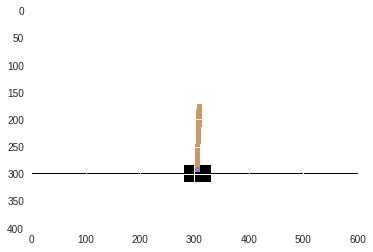

In [2]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

In [0]:
s0 = env.reset()

In [0]:
s1, r0, is_done, _ = env.step(1)

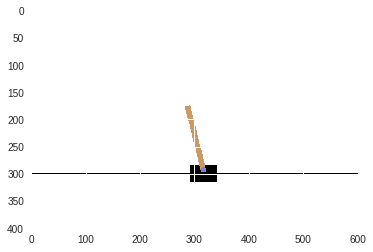

In [13]:
s0 = env.reset()
left, right = 0, 1
while True:
  s1, r0, is_done, _ = env.step(right)
  if is_done: break

plt.imshow(env.render("rgb_array"))

In [14]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.1-cp36-cp36m-linux_x86_64.whl

    100% |████████████████████████████████| 483.0MB 1.2MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x57020000 @  0x7fdf6fb5b2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states. Let's define such a model below.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [0]:
# Build a simple neural network that predicts policy logits. Keep it simple: CartPole isn't worth deep architectures.
agent = nn.Sequential(
    torch.nn.Linear(4, 102),
    torch.nn.ReLU(),
    torch.nn.Linear(102, 2),
)
# < YOUR CODE HERE: define a neural network that predicts policy logits >


#### Predict function

In [0]:
def predict_proba(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability
#     <your code here>
    states = torch.FloatTensor(states)
    return F.softmax(agent(states), dim = -1).data.numpy()


In [0]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_proba(test_states)
assert isinstance(test_probas, np.ndarray), "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], n_actions), "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis = 1), 1), "probabilities do not sum to 1"

### Play the game

We can now use our newly built agent to play the game.

In [0]:
def generate_session(t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions andrewards
    """
    
    #arrays to record session
    states, actions, rewards = [],[],[]
    
    s = env.reset()
    
    for t in range(t_max):
        
        #action probabilities array aka pi(a|s)
        action_probas = predict_proba(np.array([s]))[0] 
        
        a = np.random.choice(np.arange(n_actions), p=action_probas)
        
        new_s, r, done, info = env.step(a)
        
        #record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    return states, actions, rewards

In [0]:
# test it
states, actions, rewards = generate_session()

### Computing cumulative rewards

In [0]:
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative returns (a.k.a. G(s,a) in Sutton '16)
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute G_t = r_t + gamma*G_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    
    G = [0.]
    
    for r in reversed(rewards[:-1]):
      G.insert(0, gamma * G[0] + r)      
    return G

In [41]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(get_cumulative_rewards([0,0,1,0,0,1,0],gamma=0.9),[1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,-2,3,-4,0],gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,2,3,4,0],gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


Following the REINFORCE algorithm, we can define our objective as follows: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [0]:
def to_one_hot(y, n_dims=None):
    """ Take an integer vector (tensor of variable) and convert it to 1-hot matrix. """
    y_tensor = y.data if isinstance(y, Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return Variable(y_one_hot) if isinstance(y, Variable) else y_one_hot

In [0]:
# Your code: define optimizers
opt = torch.optim.Adam(agent.parameters())

def train_on_session(states, actions, rewards, gamma = 0.99):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """
    
    # cast everything into a variable
    states = Variable(torch.FloatTensor(states))
    actions = Variable(torch.IntTensor(actions))
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = Variable(torch.FloatTensor(cumulative_returns))
    
    # predict logits, probas and log-probas using an agent. 
    logits = agent(states)
    probas = F.softmax(logits, dim=-1)
    logprobas = F.log_softmax(logits, dim=-1)
    
    assert all(isinstance(v, Variable) for v in [logits, probas, logprobas]), \
        "please use compute using torch tensors and don't use predict_proba function"
    
    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    logprobas_for_actions = torch.sum(logprobas * to_one_hot(actions), dim = 1)
    
    # REINFORCE objective function
    J_hat = torch.mean(logprobas_for_actions * cumulative_returns)
    
    #regularize with entropy
    entropy_reg = - torch.sum(probas * logprobas, -1).mean()
    
    loss = - J_hat - 0.1 * entropy_reg
    
    # Gradient descent step
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # technical: return session rewards to print them later
    return np.sum(rewards)


### The actual training

In [48]:
for i in range(100):
    
    rewards = [train_on_session(*generate_session()) for _ in range(100)] #generate new sessions
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 500:
        print ("You Win!") # but you can train even further
        break
        


mean reward:24.170
mean reward:32.170
mean reward:50.670
mean reward:68.370
mean reward:108.680
mean reward:123.670
mean reward:193.610
mean reward:262.200
mean reward:185.180
mean reward:137.470
mean reward:144.250
mean reward:153.920
mean reward:330.070
mean reward:410.870
mean reward:193.450
mean reward:204.830
mean reward:376.160
mean reward:503.080
You Win!


### Video

In [49]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [50]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices